In [2]:
import cv2

import numpy as np;
import tifffile
import os
import matplotlib.pyplot as plt

In [76]:
# From: https://stackoverflow.com/questions/8076889/how-to-use-opencv-simpleblobdetector

# Get images with segmentation

which_slice = 15
alpha = 0.15

f = lambda tif : (alpha*tif.asarray()[which_slice]).astype('uint8')

dat_foldername = r'..\point_cloud_alignment'

vol0 = os.path.join(dat_foldername, 'img100.tif')
with tifffile.TiffFile(vol0) as tif:
    im1_raw = f(tif)

vol1 = os.path.join(dat_foldername, 'img101.tif')
with tifffile.TiffFile(vol1) as tif:
    im2_raw = f(tif)

## Simplest: find peaks

In [109]:
from skimage.feature import peak_local_max

<IPython.core.display.Javascript object>


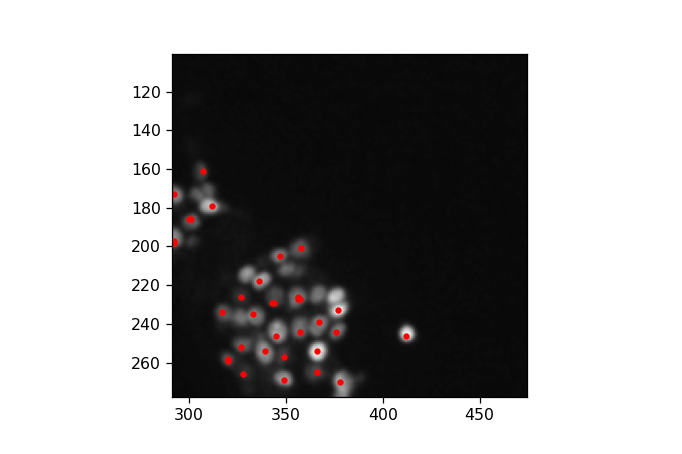

In [138]:
# Background subtraction:
# https://docs.opencv.org/3.3.0/db/d5c/tutorial_py_bg_subtraction.html
# Peak detection:
# https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_peak_local_max.html

#im1 = np.abs(cv2.GaussianBlur(im1_raw,(3,3),0) - np.min(im1_raw))
im1 = cv2.GaussianBlur(im1_raw,(3,3),0)
fgbg = cv2.createBackgroundSubtractorKNN()
fgbg.apply(im1)

%matplotlib notebook
plt.imshow(im1)

thresh = np.mean(im1)+10
coordinates = peak_local_max(im1, min_distance=5, num_peaks=200, threshold_abs=thresh)

In [139]:

plt.imshow(im1, cmap=plt.cm.gray)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')

## Thresholds

In [102]:
# Do some preprocessing
# From: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html
# Otsu's thresholding
im1 = cv2.GaussianBlur(im1_raw,(5,5),0)
#ret2,im1 = cv2.threshold(im1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
im1 = cv2.adaptiveThreshold(im1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

# Make neurons dark spts
#im1 = cv2.bitwise_not(im1)

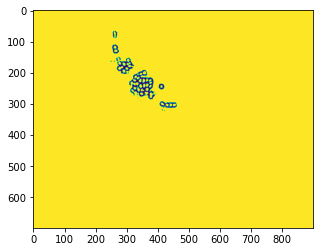

In [103]:
%matplotlib inline
plt.imshow(im1)

## Contours

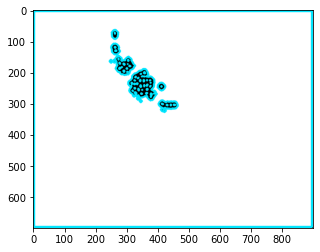

In [107]:
# Just find contours
%matplotlib inline
contours, hierarchy = cv2.findContours(im1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

im = np.expand_dims(im1, axis=2).repeat(3, axis=2) 
for k, _ in enumerate(contours):
    im = cv2.drawContours(im, contours, k, (0, 230, 255), 6)
plt.imshow(im)

## Blob detector

In [171]:
im1 = cv2.GaussianBlur(im1_raw,(5,5),0)
# im1 = cv2.bilateralFilter(im1_raw, 5, 0, 3)

im1 = cv2.bitwise_not(im1)

# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 0
params.maxThreshold = np.max(im1)
params.thresholdStep = 1

params.minDistBetweenBlobs = 2

# Filter by Area.
params.filterByArea = True
params.minArea = 5
params.maxArea = 25

# Filter by Circularity
params.filterByCircularity = False
params.minCircularity = 0.5

# Filter by Convexity
params.filterByConvexity = False
params.minConvexity = 0.2

# Filter by Inertia
params.filterByInertia = False
params.minInertiaRatio = 0.01

# Create a detector with the parameters
#detector = cv2.SimpleBlobDetector(params)
detector = cv2.SimpleBlobDetector_create(params)

In [172]:
# Detect blobs.
keypoints = detector.detect(im1)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures
# the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(im1, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show blobs
#cv2.imshow("Keypoints", im_with_keypoints)

<IPython.core.display.Javascript object>


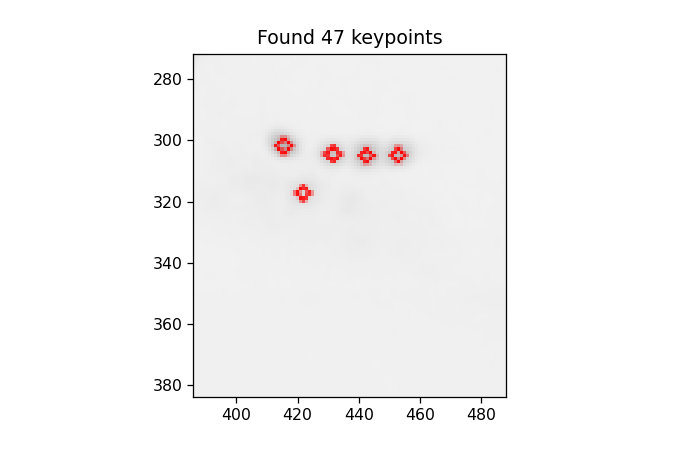

Text(0.5, 1.0, 'Found 47 keypoints')

In [173]:
%matplotlib notebook
plt.imshow(im_with_keypoints)
plt.title(f"Found {len(keypoints)} keypoints")